In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:

df2 = pd.read_csv('songs_data.csv', header=0)  # , dtype=str)
df2.head()
df2.isnull().sum()

Artist              0
Song                0
Year                0
Popularity          0
Track_id            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

### Something may looked weird here for me. 
### It seems popularity was stored as strings.
### I'll switch it to intergers.
### <br>
### This may be different if you loaded a csv but you can still run this code.

In [3]:
df2['Popularity'] = df2['Popularity'].apply(int)

In [4]:
df2.head()

,Artist,Song,Year,Popularity,Track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Maroon 5,Moves Like Jagger - Radio Edit,2021,1,27sv92iPJbYjaN5OPYoXDN,0.718,0.737,11,-4.654,0,0.0478,0.01280,0.000000,0.338,0.5980,128.034,201387,4
1,Coldplay,Sparks,2000,74,7D0RhFcb3CrfPuTJ0obrod,0.371,0.268,1,-10.506,1,0.0281,0.74800,0.051700,0.104,0.1650,102.617,227093,3
2,The Cranberries,Zombie - Acoustic Version,2017,63,1qylvO4iCIZZcqc4TqSjTZ,0.469,0.427,4,-7.954,0,0.0241,0.00414,0.000038,0.128,0.0821,84.053,241560,4
3,Logic,Stupid Skit,2021,61,0aROixALIghwvjNG4iD8pI,0.838,0.694,11,-6.234,1,0.1760,0.18900,0.000129,0.131,0.7830,77.037,49535,4
4,Jason Mraz,I'm Yours,2008,80,1EzrEOXmMH3G43AXT1y7pA,0.686,0.457,11,-8.322,1,0.0468,0.59500,0.000000,0.105,0.7180,150.953,242187,4


## Start the modeling here.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

### Drop unnecessary or non-numeric columns.
### Convert the features to float just to make sure.
###     <br>
### Is leaving the year in data leakage? Newer songs will usually be more popular?
### Could solve this by only looking at songs from a certain period (e.g. a decade).

In [6]:
X = df2.drop(['Artist', 'Song', 'Popularity', 'time_signature', 'Track_id'], axis=1)
X.astype(float, copy=False)
y = df2['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Start with a decision tree regressor and then compare to different models.

### Comparison of random forest and decision tree feature importances shows they are quite similar.
### Year is the most important for both of these with mode being the lowest.

In [7]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [59]:
gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist'
}

model = xgb.XGBRegressor(**gpu_dict)
xgbfit = model.fit(X_train, y_train)
xgb_pred = xgbfit.predict(X_test)

Text(0, 0.5, 'Predicted Y')

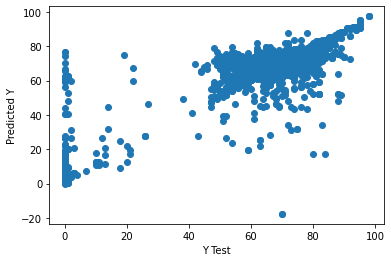

In [60]:
plt.scatter(y_test, xgb_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [61]:
print('R2:', metrics.r2_score(y_test, xgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))

R2: 0.741882325030947
RMSE: 9.33444133485393


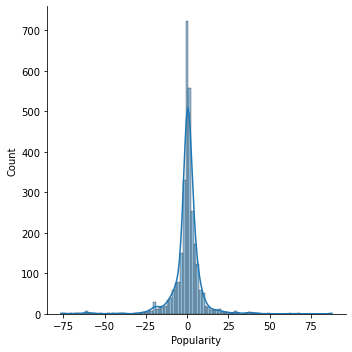

In [70]:
ax = sns.displot((y_test-xgb_pred), bins=100, kde=True)

## Random Forest gave the best fit followed by XGBoost and then Decision Tree. 
## RF and DT gave similar results for the feature importance.
## <br>
## It would likely be possible to get a better fit with XGB by opitimizing the hyperparamters - 
## (See the XBG notebook.. not that much better than RF)
## <br>
## Therefore, I continued with only Random Forest.

In [49]:
# Get names of indexes for which pop is < 10
indexNames = df2[ df2['Popularity'] < 10 ].index
# Delete these row indexes from dataFrame

df2.drop(indexNames , inplace=True)

X = df2.drop(['Artist', 'Song', 'Popularity', 'time_signature', 'Track_id'], axis=1)
X.astype(float, copy=False)
y = df2['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Text(0, 0.5, 'Predicted Y')

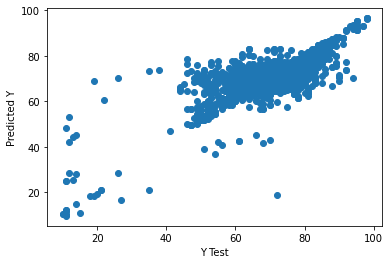

In [65]:
gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist'
}

xgbmodel = xgb.XGBRegressor(**gpu_dict)
xgbfit = xgbmodel.fit(X_train, y_train)
xgb_pred = xgbfit.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, xgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, xgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))

plt.scatter(y_test, xgb_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

Feature: 0, Score: 0.05990
Feature: 1, Score: 0.04911
Feature: 2, Score: 0.05572
Feature: 3, Score: 0.04949
Feature: 4, Score: 0.08779
Feature: 5, Score: 0.07904
Feature: 6, Score: 0.06150
Feature: 7, Score: 0.07471
Feature: 8, Score: 0.10014
Feature: 9, Score: 0.07300
Feature: 10, Score: 0.08105
Feature: 11, Score: 0.07746
Feature: 12, Score: 0.15110


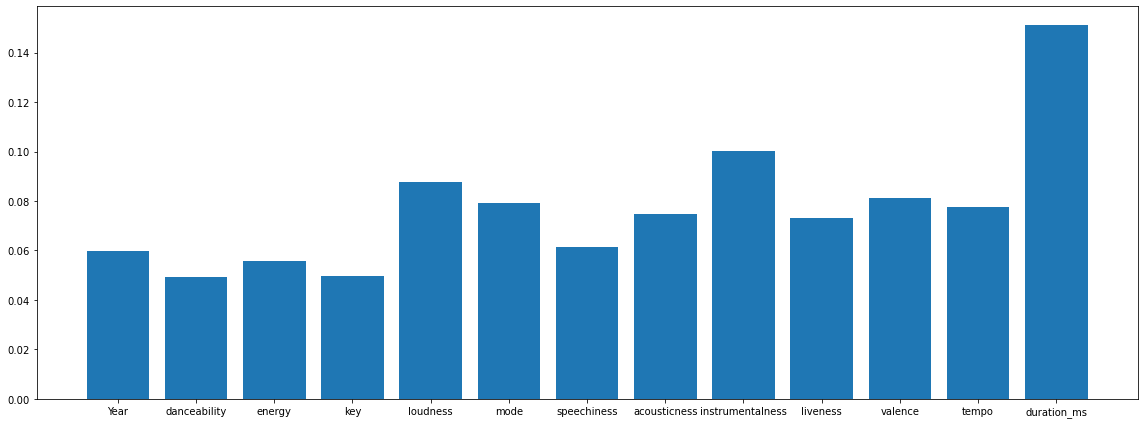

In [54]:
importance = xgbfit.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig = plt.figure(figsize=(16,6))
plt.bar([x for x in X.columns], importance)
plt.tight_layout()
plt.show()

MAE: 3.040554048130212
MSE: 30.225358635401776
RMSE: 5.497759419563735


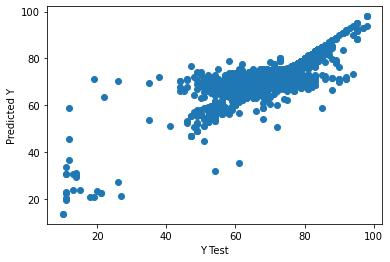

In [52]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

plt.scatter(y_test, rfr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

Feature: 0, Score: 0.06275
Feature: 1, Score: 0.07090
Feature: 2, Score: 0.06692
Feature: 3, Score: 0.03517
Feature: 4, Score: 0.11164
Feature: 5, Score: 0.00839
Feature: 6, Score: 0.07049
Feature: 7, Score: 0.07955
Feature: 8, Score: 0.06387
Feature: 9, Score: 0.08182
Feature: 10, Score: 0.10202
Feature: 11, Score: 0.09051
Feature: 12, Score: 0.15597


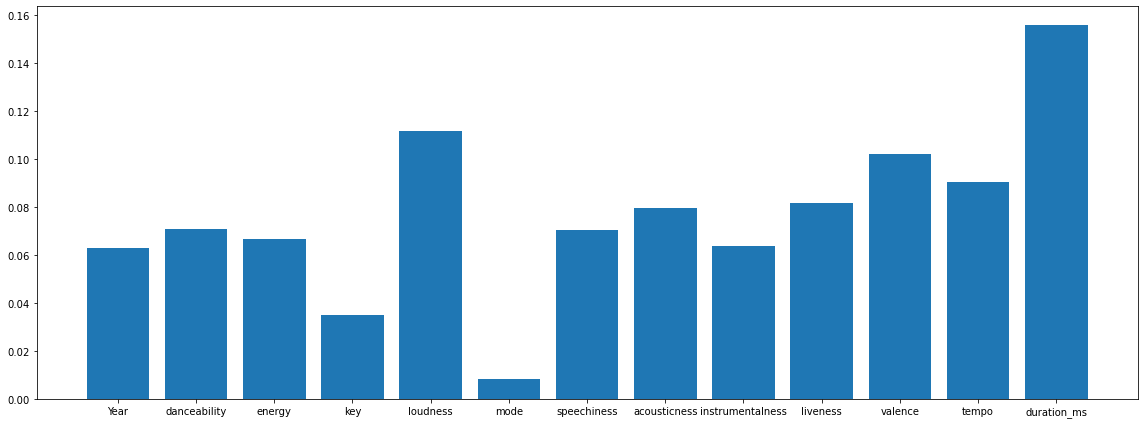

In [53]:
importance = rfr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig = plt.figure(figsize=(16,6))
plt.bar([x for x in X.columns], importance)
plt.tight_layout()
plt.show()

MAE: 3.1629055007052185
MSE: 52.06911142454161
RMSE: 7.215892974853605


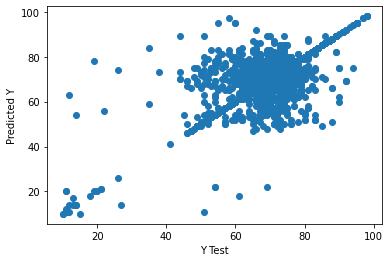

In [55]:
rtree = DecisionTreeRegressor()
rtree.fit(X_train, y_train)
predictions = rtree.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Feature: 0, Score: 0.06696
Feature: 1, Score: 0.08402
Feature: 2, Score: 0.06535
Feature: 3, Score: 0.04036
Feature: 4, Score: 0.10663
Feature: 5, Score: 0.00751
Feature: 6, Score: 0.07278
Feature: 7, Score: 0.05547
Feature: 8, Score: 0.05276
Feature: 9, Score: 0.07055
Feature: 10, Score: 0.08143
Feature: 11, Score: 0.11347
Feature: 12, Score: 0.18273


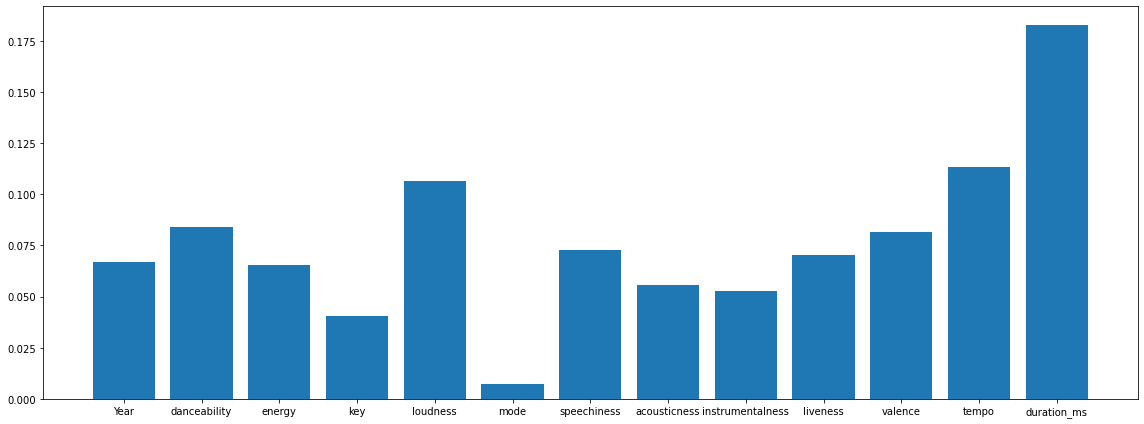

In [56]:
importance = rtree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig = plt.figure(figsize=(16,6))
plt.bar([x for x in X.columns], importance)
plt.tight_layout()
plt.show()

Feature: 0, Score: 15.35908
Feature: 1, Score: 12.19473
Feature: 2, Score: 11.61061
Feature: 3, Score: 6.87552
Feature: 4, Score: 21.92238
Feature: 5, Score: 1.66907
Feature: 6, Score: 10.53952
Feature: 7, Score: 16.24565
Feature: 8, Score: 10.38488
Feature: 9, Score: 14.30811
Feature: 10, Score: 17.11778
Feature: 11, Score: 14.41134
Feature: 12, Score: 23.38699


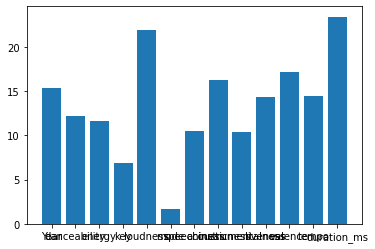

In [66]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
model = KNeighborsRegressor()
# fit the model
model.fit(X_train, y_train)
# perform permutation importance
results = permutation_importance(xgbmodel, X_train, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in X.columns], importance)
pyplot.show()

Feature: 0, Score: 15.04259
Feature: 1, Score: 12.08680
Feature: 2, Score: 11.50799
Feature: 3, Score: 6.84930
Feature: 4, Score: 22.22778
Feature: 5, Score: 1.49185
Feature: 6, Score: 10.57254
Feature: 7, Score: 16.38213
Feature: 8, Score: 10.63859
Feature: 9, Score: 14.16267
Feature: 10, Score: 16.91391
Feature: 11, Score: 14.32821
Feature: 12, Score: 23.25226


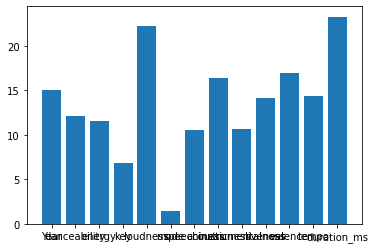

In [67]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
model = KNeighborsRegressor()
# fit the model
model.fit(X_train, y_train)
# perform permutation importance
results = permutation_importance(xgbfit, X_train, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in X.columns], importance)
pyplot.show()

In [70]:
X = df2.drop(['Artist', 'Song', 'Popularity', 'time_signature', 'Track_id', 'Year'], axis=1)
X.astype(float, copy=False)
y = df2['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

MAE: 3.092146481153622
MSE: 32.00853738276198
RMSE: 5.657608804323782


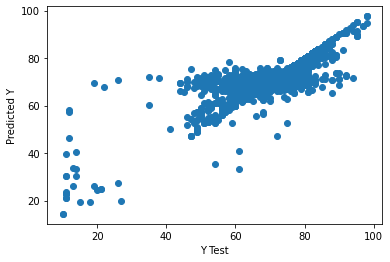

In [71]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

plt.scatter(y_test, rfr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

Feature: 0, Score: 0.08036
Feature: 1, Score: 0.07110
Feature: 2, Score: 0.03827
Feature: 3, Score: 0.11364
Feature: 4, Score: 0.00884
Feature: 5, Score: 0.07676
Feature: 6, Score: 0.09257
Feature: 7, Score: 0.06813
Feature: 8, Score: 0.08852
Feature: 9, Score: 0.10451
Feature: 10, Score: 0.09144
Feature: 11, Score: 0.16587


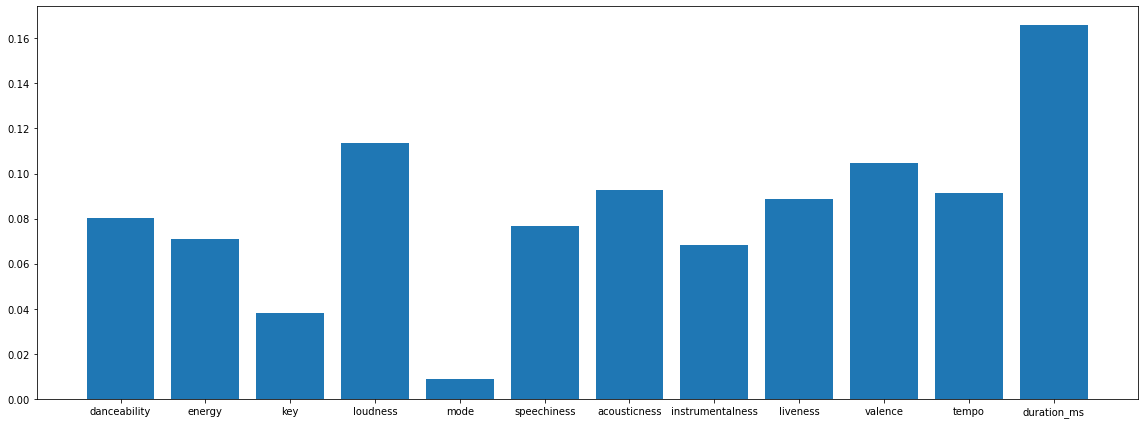

In [72]:
importance = rfr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig = plt.figure(figsize=(16,6))
plt.bar([x for x in X.columns], importance)
plt.tight_layout()
plt.show()

In [75]:
X = df2.drop(['Artist', 'Song', 'Popularity', 'time_signature', 'Track_id', 'Year', 'mode', 'key'], axis=1)
X.astype(float, copy=False)
y = df2['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

MAE: 3.1107161509642998
MSE: 31.95319489905423
RMSE: 5.6527157100861025


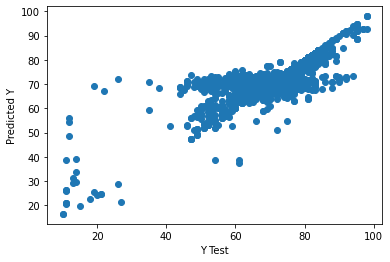

In [87]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

plt.scatter(y_test, rfr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

Feature: 0, Score: 0.08225
Feature: 1, Score: 0.07608
Feature: 2, Score: 0.11843
Feature: 3, Score: 0.08131
Feature: 4, Score: 0.09722
Feature: 5, Score: 0.07229
Feature: 6, Score: 0.09376
Feature: 7, Score: 0.11101
Feature: 8, Score: 0.09913
Feature: 9, Score: 0.16853


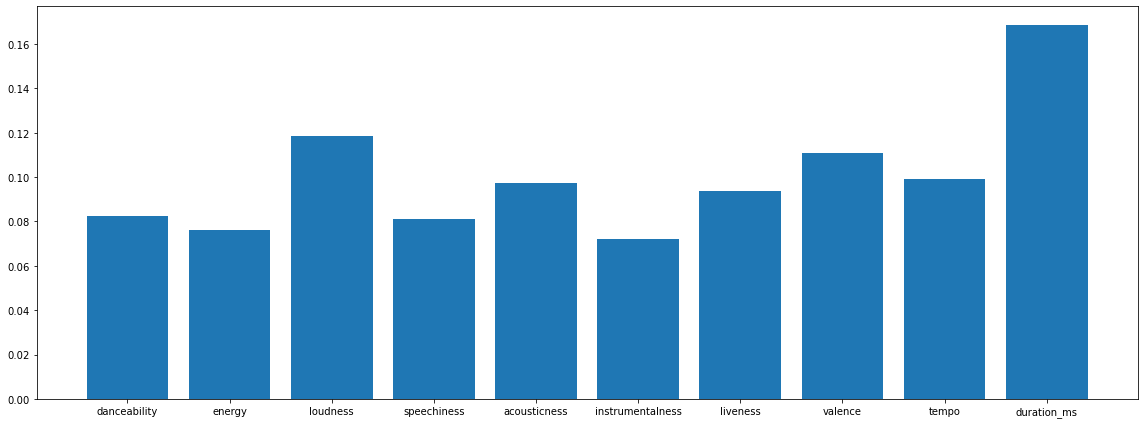

In [88]:
importance = rfr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig = plt.figure(figsize=(16,6))
plt.bar([x for x in X.columns], importance)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Predicted Y')

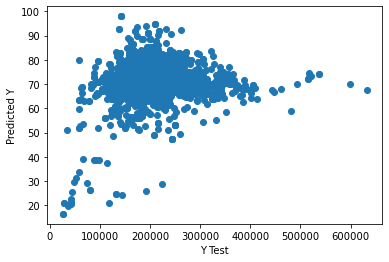

In [89]:
plt.scatter(X_test['duration_ms'], rfr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')


In [94]:
from sklearn.metrics import explained_variance_score, r2_score
print(explained_variance_score(y_test, rfr_pred))
print(r2_score(y_test, rfr_pred))

0.6808498211702155
0.6788276087658336


In [95]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [148]:
space={'max_depth': hp.quniform("max_depth", 3, 21, 1),
        'gamma': hp.uniform ('gamma', 0, 5),
        'reg_alpha' : hp.quniform('reg_alpha', 0, 15, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        # 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 250,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators=space['n_estimators'],
                    max_depth=int(space['max_depth']),
                    gamma=space['gamma'],
                    reg_alpha=int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    # colsample_bytree=int(space['colsample_bytree']),
                    tree_method='gpu_hist',
                    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, #eval_metric="reg:squarederror",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = r2_score(y_test, pred)
    print("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [149]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.653826605234891
SCORE:
0.6413362905987232
SCORE:
0.6446211438177736
SCORE:
0.6455803319290607
SCORE:
0.6459092147536982
SCORE:
0.6548784583628673
SCORE:
0.6303912421672857
SCORE:
0.644948434443916
SCORE:
0.6507660525725678
SCORE:
0.649451402236506
SCORE:
0.6473967411872956
SCORE:
0.6455138644000924
SCORE:
0.5877661026409664
SCORE:
0.6678701194431202
SCORE:
0.6420393166335288
SCORE:
0.6498614711371024
SCORE:
0.665157749403963
SCORE:
0.6434749738033443
SCORE:
0.6552440045241364
SCORE:
0.6087697114393928
SCORE:
0.6490503254706284
SCORE:
0.671571765550663
SCORE:
0.6515245625928837
SCORE:
0.6737600543773359
SCORE:
0.6576464811068845
SCORE:
0.6587011655409254
SCORE:
0.6618483345042534
SCORE:
0.6530249426021418
SCORE:
0.6565001551674112
SCORE:
0.6555586599493535
SCORE:
0.6592794075708075
SCORE:
0.6692011763539674
SCORE:
0.6655869767725364
SCORE:
0.6437142178317261
SCORE:
0.675494633548435
SCORE:
0.654105927550105
SCORE:
0.6501426666493071
SCORE:
0.6253286813858514
SCORE:
0.6658238776

In [150]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'gamma': 0.280815534329248, 'max_depth': 8.0, 'min_child_weight': 6.0, 'reg_alpha': 5.0, 'reg_lambda': 0.5915135132672407}


In [ ]:
gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
}

gpu_dict = gpu_dict | best_hyperparams

In [153]:
gpu_dict['max_depth'] = int(gpu_dict['max_depth'])
print(gpu_dict)

{'objective': 'reg:squarederror', 'tree_method': 'gpu_hist', 'gamma': 0.280815534329248, 'max_depth': 8, 'min_child_weight': 6.0, 'reg_alpha': 5.0, 'reg_lambda': 0.5915135132672407}


MAE: 2.9534759972932814
MSE: 34.41718877928303
RMSE: 5.866616467716551
0.654061171199903


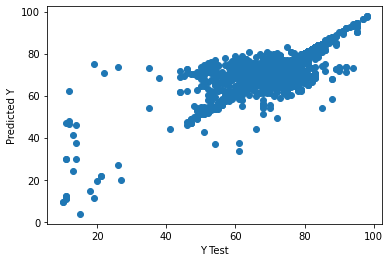

In [154]:
xgbmodel = xgb.XGBRegressor(**gpu_dict)
xgbfit = xgbmodel.fit(X_train, y_train)
xgb_pred = xgbfit.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, xgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, xgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))

plt.scatter(y_test, xgb_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

print(r2_score(y_test, xgb_pred))

In [108]:
xgb.get_config()

{'use_rmm': False, 'verbosity': 1}